In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import mlflow
import segmentation_models_pytorch as smp
from torchvision.transforms import ToPILImage

from cosas.tracking import get_experiment
from cosas.paths import DATA_DIR
from cosas.data_model import COSASData, Scanncers
from cosas.datasets import Patchdataset
from cosas.misc import set_seed, train_val_split

/home/heon/anaconda3/envs/cosas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

DEVICE = "cuda"
set_seed(42)  # TODO

cosas_data = COSASData(os.path.join(DATA_DIR, "task2"))
cosas_data.load()

(train_images, train_masks), (val_images, val_masks), (test_images, test_masks) = (
    train_val_split(cosas_data, train_val_test=(0.6, 0.2, 0.2))
)

model = smp.FPN(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    classes=1,
    activation=None,
).to(DEVICE)


#### cosas.datasets

(224, 224, 3) uint8
(224, 224, 1) uint8


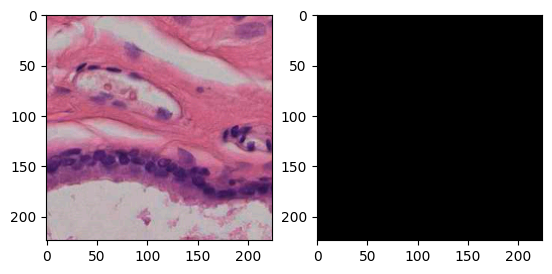

In [4]:
import random
import numpy as np
from matplotlib import pyplot as plt

from cosas.datasets import Patchdataset
patchdataset = Patchdataset(train_images, train_masks, device="cpu")
idx = random.sample(range(len(patchdataset)), 1)[0]
x, y = patchdataset[idx]
print(x.shape, x.dtype)
print(y.shape, y.dtype)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(x)
axes[1].imshow(y, cmap="gray", vmin=0, vmax=1)

tensor(0.4699) tensor(0.0766)
torch.Size([3, 224, 224]) torch.float32
torch.Size([224, 224, 1]) torch.uint8


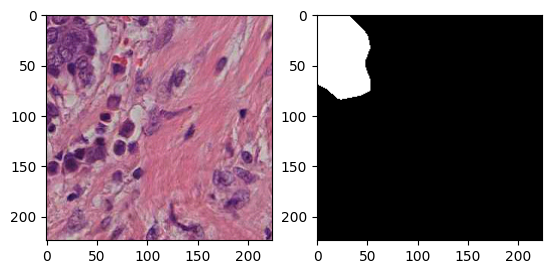

In [5]:
import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from cosas.datasets import Patchdataset
from torchvision.transforms import ToPILImage

mean = [0.485, 0.456, 0.406]
sd = [0.229, 0.224, 0.225]
test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=sd),
        ToTensorV2(), # [0,1 정규화안시킴]
    ]
)
patchdataset = Patchdataset(train_images, train_masks, test_transform, device="cpu")
x, y = patchdataset[0]
print(x.mean(), y.mean(dtype=torch.float32))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(ToPILImage()(x * torch.tensor(sd)[:, None, None] + torch.tensor(mean)[:, None, None]))
axes[1].imshow(y, cmap="gray", vmin=0, vmax=1)

tensor(0.3349) tensor(0.3662)
torch.Size([42, 3, 224, 224]) torch.float32
torch.Size([42, 224, 224, 1]) torch.float32 tensor(1.) tensor(0.)


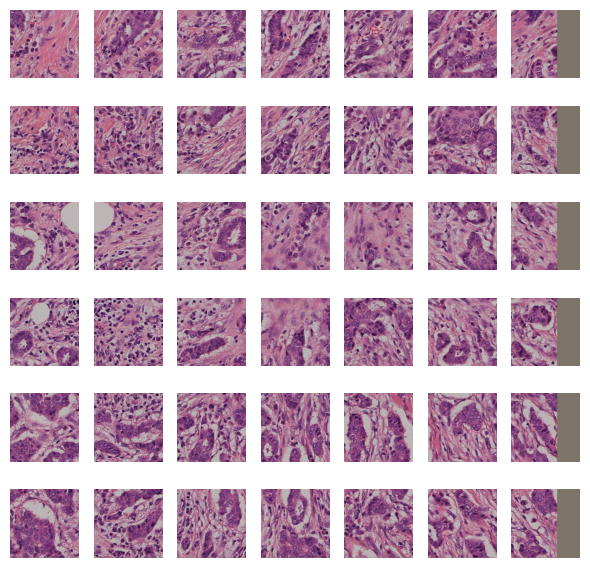

In [6]:
import albumentations as A
import torch
from matplotlib import pyplot as plt
from cosas.datasets import WholeSizeDataset

mean = [0.485, 0.456, 0.406]
sd = [0.229, 0.224, 0.225]
test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=sd),
        ToTensorV2(), # [0,1 정규화안시킴]
    ]
)
wholesize_ds = WholeSizeDataset(train_images, train_masks, test_transform, device="cpu")
raw_xs, raw_ys = wholesize_ds[0]
print(raw_xs.mean(), raw_ys.mean(dtype=torch.float32))
print(raw_xs.shape, raw_xs.dtype)
print(raw_ys.shape, raw_ys.dtype, raw_ys.max(), raw_ys.min())

mean = [0.485, 0.456, 0.406]
sd = [0.229, 0.224, 0.225]

fig, ax = plt.subplots(figsize=(6, 6), nrows=6, ncols=7)
for n, x in enumerate(raw_xs):
    original_x = ToPILImage()(x * torch.tensor(sd)[:, None, None] + torch.tensor(mean)[:, None, None])
    ax.flat[n].imshow(original_x)
    ax.flat[n].axis("off")

plt.tight_layout()
plt.show()

#### casas.trainer

In [15]:
import torch
from torch.utils.data import DataLoader
from cosas.trainer import BinaryClassifierTrainer
from cosas.tracking import TRACKING_URI, get_experiment

train_transform = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )

train_dataset = Patchdataset(train_images, train_masks, train_transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
)

test_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = Patchdataset(val_images, val_masks, test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
n_steps = len(train_dataloader)
trainer = BinaryClassifierTrainer(
    model, 
    torch.nn.functional.binary_cross_entropy_with_logits, 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
)

mlflow.set_tracking_uri(TRACKING_URI)
experiment = get_experiment("cosas")

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="ipynb") as run:
    # trainer.run_train_epoch(1, train_dataloader)
    # trainer.run_test_epoch(1, val_dataloader)
    # trainer.run_test_epoch(1,)
    # trainer.train(
    #     train_dataloader,
    #     val_dataset,
    #     epochs=1,
    #     n_patience=7,
    # )
    mlflow.pytorch.log_model(trainer.model, "model")

    # test_loss, test_metrics = trainer.test(
    #     WholeSizeDataset(test_images, test_masks, test_transform), 
    #     phase="test",
    #     epoch=0,
    #     threshold=0.5,
    #     save_plot=True
    # )
    # mlflow.log_metric("test_loss", test_loss.avg)
    # mlflow.log_metrics(test_metrics.to_dict(prefix="test_"))

/home/heon/anaconda3/envs/cosas/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/heon/anaconda3/envs/cosas/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [ ]:
from cosas.transforms import reverse_tesellation, remove_pad
x,y = WholeSizeDataset(test_images, test_masks, test_transform)[0]
pred_y = torch.sigmoid(model(x))
size = test_images[0].shape[:2]
original_y = remove_pad(reverse_tesellation(pred_y, size), size)
plt.imshow(ToPILImage()(original_y), cmap="gray")# , vmin=0, vmax=1)

### Test

In [ ]:
import mlflow
import torch
import albumentations as A 
from cosas.tracking import TRACKING_URI
from cosas.datasets import WholeSizeDataset
from torchvision.transforms import ToPILImage
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
mlflow.set_tracking_uri(TRACKING_URI)

model = mlflow.pytorch.load_model(
    "file:///vast/AI_team/mlflow_artifact/13/34d8d87241d847c3b239d360eb2e6d5b/artifacts/model"
).eval()

transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

image_idx = 20
with torch.no_grad():
    test_dataset = WholeSizeDataset(test_images, test_masks, transform)
    xs, ys = test_dataset[image_idx]
    logits = model(xs)
    confidences = torch.sigmoid(logits)


ToPILImage()(confidences.detach()[image_idx])
# plt.imshow(ToPILImage())

#### cosas.transforms

In [ ]:
from cosas.transforms import reverse_tesellation, remove_pad

original_size = test_masks[1].shape
test_mask = reverse_tesellation(ys, original_size)
res = remove_pad(test_mask, original_size)

plt.imshow(ToPILImage()(res))

### cosas.misc

In [ ]:
from cosas.misc import plot_xypred

plot_xypred(
    test_images[1], 
    test_masks[1], 
    confidences
)